# Predicting Number of Degrees Awarded
## Jagos 
### 02/25/2022

### Introduction
Graduation rates in addition to retention rates are some of the most important statistics for educational institutions. Federal student aid defines it as, "the percentage of a school's first-time, first-year undergraduate students who complete their program within 150% of the published time for the program." High graduation rates demonstrate a school's commitment to students, reflecting a high level of institutional support and overall effectiveness. In this report I predict graduation rates by modeling the number of bachelors degrees awarded at an institution using various socio-economic variables. Additionally since the target variable is degrees awarded, this will also include retention rates to some extent as students need to stick around to get their degrees. Lastly I identify 3 most stand out features/variables that influence the main variable.

### Lit Review
The usage of machine learning in educational studies is new with most of the sources dated between 2014 and 2021. These papers focused on predicting student success and identifying students who needed immediate assistance. Uskov et al for example used standard models such as k-nearest neighbor classification, naïve Bayes, artificial neural network (ANN) regression and classification, decision tree classification, random forest classification, and support vector machine classification to predict student academic performance in STEM education. Ahadi et al used similar models in addition to using Pearson's correlation to select features. In both papers random forest and ANN significantly outperformed in their tasks. Therefore, in this report I will be focusing on those 2. Lastly, the paper by Golino et al only used random forest to classify students in a Computer Science class and predict their academic achievement. The model was able to achieve a 75% accuracy. Overall, the literature is plentiful and the methodologies robust. This report only contributes to the literature in scale, that is the data used is not focused on classrooms or individual schools but more on the national level.

### Methodology
The data comes from the National Center for Education Statistics, more specifically IPEDS Analytics: Delta Cost Project Database. There you will find a longitudinal database derived from IPEDS finance, enrollment, staffing, completions and student aid data for academic years 1986-87 through 2011-12. I will talk about my methodology as we go through the code.

#### Importing packages and dataset

In [1]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
from sklearn.tree import plot_tree
%matplotlib inline 

In [2]:
# Importing dataset
df = pd.read_csv('delta_public_00_12.csv',encoding='latin1', low_memory = False)

In [3]:
df.shape

(87560, 974)

#### Feature Selection
The dataset cointains 974 variables with our variable of interest "bachelordegrees". In order to reduce model complexity, enhance efficiency, and reduce noise we need to perform some sort of feature selection. First I used the pandas package to visualize the correlations of every variable. Based on the literature as well as the figure I picked the variables with the highest correlation to the target variable. 

In [ ]:
# Notebook won't show on github if i run it
"""""
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [4]:
# Making a new subset with selected features
df_subset = df[['bachelordegrees','sector','flagship','state03',
                'private03','edactivity03','unrestricted_revenue','appliedaid01',
                'grant01','grant02','grant03','grant05','grant06','grant07',
                'institutional_grant_aid',
               'any_aid_num','loan_num','acadsupp01','acadsupp01_fasb','acadsupp02','studserv01',
               'studserv01_fasb','ftretention_rate','total_enrollment_amin_tot',
               'dependent1']]
df_subset

,bachelordegrees,sector,flagship,state03,private03,edactivity03,unrestricted_revenue,appliedaid01,grant01,grant02,...,any_aid_num,loan_num,acadsupp01,acadsupp01_fasb,acadsupp02,studserv01,studserv01_fasb,ftretention_rate,total_enrollment_amin_tot,dependent1
0,20.0,3,0,NaN,NaN,NaN,2895011.0,20138.0,1046625.0,211276.0,...,12.0,12.0,NaN,NaN,NaN,882337.717575,NaN,1.00,3.0,NaN
1,NaN,9,0,NaN,9000.0,NaN,947300.0,196340.0,198269.0,NaN,...,19.0,15.0,NaN,NaN,NaN,106040.267022,NaN,0.69,0.0,NaN
2,516.0,2,0,NaN,NaN,NaN,21079005.0,2067400.0,4390892.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN
3,NaN,9,0,NaN,NaN,NaN,699988.0,NaN,393685.0,NaN,...,13.0,13.0,NaN,NaN,NaN,NaN,NaN,0.84,0.0,NaN
4,NaN,6,0,NaN,NaN,NaN,1130401.0,18397.0,361836.0,11101.0,...,101.0,96.0,NaN,NaN,NaN,867440.029060,NaN,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87555,23.0,3,0,NaN,NaN,NaN,5033370.0,74168.0,1306516.0,42408.0,...,33.0,28.0,NaN,NaN,NaN,795911.296036,NaN,0.50,1.0,NaN
87556,29.0,3,0,NaN,NaN,NaN,8864391.0,261221.0,1070872.0,33008.0,...,21.0,17.0,NaN,NaN,NaN,452589.373268,NaN,0.58,1.0,NaN
87557,3.0,3,0,NaN,NaN,NaN,1627658.0,60055.0,382504.0,18250.0,...,10.0,10.0,NaN,NaN,NaN,157952.111494,NaN,0.50,1.0,NaN
87558,8.0,3,0,NaN,NaN,NaN,2165955.0,72265.0,514270.0,15968.0,...,11.0,10.0,NaN,NaN,NaN,549126.810692,NaN,0.75,0.0,NaN


In [5]:
# Closer look at the correlations
corr = df_subset.corr()
corr.style.background_gradient(cmap='coolwarm')

,bachelordegrees,sector,flagship,state03,private03,edactivity03,unrestricted_revenue,appliedaid01,grant01,grant02,grant03,grant05,grant06,grant07,institutional_grant_aid,any_aid_num,loan_num,acadsupp01,acadsupp01_fasb,acadsupp02,studserv01,studserv01_fasb,ftretention_rate,total_enrollment_amin_tot,dependent1
bachelordegrees,1.000000,-0.283102,0.443612,0.864964,0.332659,0.323833,0.655382,0.640379,0.611473,0.436294,0.597934,0.373139,0.383406,0.717420,0.462386,0.720123,0.537300,0.642740,0.606254,0.627899,0.735065,0.707862,0.181474,0.318982,0.499271
sector,-0.283102,1.000000,-0.054644,-0.333257,-0.118081,-0.134536,-0.215602,-0.252817,-0.170538,-0.143850,-0.181949,-0.134074,-0.167137,-0.259430,-0.196535,-0.207156,-0.152774,-0.188528,-0.139860,-0.174392,-0.288265,-0.188928,0.115099,-0.145687,-0.117829
flagship,0.443612,-0.054644,1.000000,0.473107,0.166878,0.161924,0.314704,0.244463,0.135514,0.208465,0.156326,0.217385,0.173717,0.264725,0.225574,0.298521,0.210142,0.344756,0.309658,0.348759,0.277044,0.259686,0.076598,0.254484,0.130323
state03,0.864964,-0.333257,0.473107,1.000000,0.347645,0.302491,0.794386,0.618925,0.622737,0.455711,0.595245,0.494001,0.298103,0.663943,0.384363,0.819978,0.687358,0.688815,0.618852,0.654239,0.764361,0.741337,0.280724,0.277188,0.594799
private03,0.332659,-0.118081,0.166878,0.347645,1.000000,0.665106,0.680875,0.684921,0.105963,0.498024,0.130238,0.757803,0.613149,0.622183,0.739227,0.260336,0.275448,0.614204,0.635242,0.558508,0.565860,0.598809,0.249312,0.070490,0.086102
edactivity03,0.323833,-0.134536,0.161924,0.302491,0.665106,1.000000,0.511038,0.525025,0.162503,0.554708,0.192033,0.528459,0.448568,0.502227,0.548336,0.213131,0.170266,0.622805,0.622196,0.570620,0.491149,0.490302,0.106522,0.116991,0.091147
unrestricted_revenue,0.655382,-0.215602,0.314704,0.794386,0.680875,0.511038,1.000000,0.734206,0.420916,0.476604,0.399443,0.609942,0.475305,0.709133,0.605225,0.505994,0.381947,0.674233,0.639155,0.637592,0.717183,0.681415,0.128762,0.220773,0.344858
appliedaid01,0.640379,-0.252817,0.244463,0.618925,0.684921,0.525025,0.734206,1.000000,0.412961,0.512947,0.452800,0.646302,0.897593,0.910636,0.929439,0.504536,0.347252,0.676414,0.699408,0.624775,0.789647,0.821995,0.252429,0.166941,0.340611
grant01,0.611473,-0.170538,0.135514,0.622737,0.105963,0.162503,0.420916,0.412961,1.000000,0.463574,0.437717,0.155178,0.173245,0.661221,0.204971,0.714073,0.557924,0.375054,0.349018,0.364241,0.595971,0.534241,-0.046916,0.322880,0.845664
grant02,0.436294,-0.143850,0.208465,0.455711,0.498024,0.554708,0.476604,0.512947,0.463574,1.000000,0.231727,0.508765,0.329034,0.564694,0.397996,0.333281,0.270215,0.496965,0.463771,0.490092,0.511559,0.520263,0.100577,0.173946,0.237733


#### Missing Values issues
The first issue with the dataset is the amount of missing values. As you can see below there are thousands so I did my best to clean up the dataset. I simply ended up dropping the NaN values. In this case I dropped all the missing rows where bachelordegrees and state03 were missing. This was not enough because there were still so many and I could not run the dropna() command by itself because it would drop the entire dataset. Therefore I decided to impute the data using itetative imputer and KNN and scaled it using the standard scaler. More detail below.

In [6]:
# Num of missing values
df_subset.isnull().sum()

bachelordegrees              33720
sector                           0
flagship                         0
state03                      65089
private03                    51139
edactivity03                 60060
unrestricted_revenue         12374
appliedaid01                 40303
grant01                      17895
grant02                      34563
grant03                      41976
grant05                      57135
grant06                      56860
grant07                      13987
institutional_grant_aid      40362
any_aid_num                  18846
loan_num                     18885
acadsupp01                   45428
acadsupp01_fasb              59906
acadsupp02                   50719
studserv01                   19328
studserv01_fasb              59657
ftretention_rate             43293
total_enrollment_amin_tot    11291
dependent1                   55286
dtype: int64

In [7]:
# Dropping
df_subset = df_subset.dropna(subset=['bachelordegrees'],how='all')
df_subset = df_subset.dropna(subset=['state03'],how='all')
df_subset.isnull().sum()

bachelordegrees                  0
sector                           0
flagship                         0
state03                          0
private03                     4376
edactivity03                 11528
unrestricted_revenue             0
appliedaid01                  4451
grant01                        389
grant02                       1518
grant03                       2667
grant05                       5195
grant06                       3607
grant07                         84
institutional_grant_aid       1975
any_aid_num                    690
loan_num                       695
acadsupp01                     602
acadsupp01_fasb              12051
acadsupp02                    4447
studserv01                     335
studserv01_fasb              12064
ftretention_rate              8409
total_enrollment_amin_tot       41
dependent1                    4048
dtype: int64

In [8]:
df_subset.shape

(15972, 25)

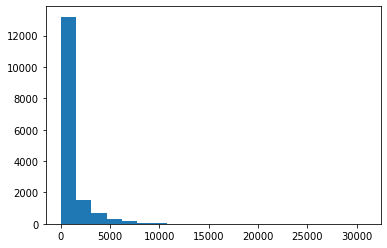

In [9]:
# Basic viz to see what we are dealing with
x = df_subset[['bachelordegrees']]
plt.hist(x, bins = 20)
plt.show()

#### Imputation Techniques
Iterative imputation refers to a process where each feature is modeled as a function of the other features. For example a regression problem where missing values are predicted. Each feature is imputed sequentially, one after the other, allowing prior imputed values to be used as part of a model in predicting subsequent features. This process is repeated multiple times, allowing ever improved estimates of missing values to be calculated as missing values across all features are estimated. Different regression algorithms can be used to estimate the missing values for each feature. In my case, I used a Bayesian ridge regression. Further I used the initial strategy median due to the fact that the dataset is skewed right. This means that the iterative imputer will initially impute the missing values with the median as it is a better measure of the central tendency of data. Feature scaling is essential for machine learning algorithms that calculate distances between data. If not scale, the feature with a higher value range starts dominating when calculating distances.
The standard scaler (z = (x - u) / s) standardizes features by removing the mean and scaling to unit variance.

In [10]:
imp = IterativeImputer(max_iter = 30, initial_strategy='median',
                      imputation_order = 'roman',sample_posterior=False)
df_mice = imp.fit_transform(df_subset)
scaler = StandardScaler()
df_mice = scaler.fit_transform(df_mice)
df_mice = pd.DataFrame(df_mice, columns = ['bachelordegrees','sector','flagship','state03',
                'private03','edactivity03','unrestricted_revenue','appliedaid01',
                'grant01','grant02','grant03','grant05','grant06','grant07',
                'institutional_grant_aid',
               'any_aid_num','loan_num','acadsupp01','acadsupp01_fasb','acadsupp02','studserv01',
               'studserv01_fasb','ftretention_rate','total_enrollment_amin_tot',
               'dependent1'])
df_mice

C:\Users\Jagos\miniconda3\envs\dsda\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,bachelordegrees,sector,flagship,state03,private03,edactivity03,unrestricted_revenue,appliedaid01,grant01,grant02,...,any_aid_num,loan_num,acadsupp01,acadsupp01_fasb,acadsupp02,studserv01,studserv01_fasb,ftretention_rate,total_enrollment_amin_tot,dependent1
0,-0.472282,-0.388621,-0.197223,-0.448377,-0.226208,-0.147643,-0.447012,-0.331050,-0.437377,-0.250356,...,-0.430831,-0.329016,-0.381731,-0.382194,-0.367817,-0.537373,-0.546777,-0.094636,-0.331740,-0.412021
1,-0.487343,-0.388621,-0.197223,-0.448369,-0.226311,-0.147829,-0.445136,-0.331888,-0.439414,-0.268806,...,-0.437858,-0.338579,-0.379107,-0.379757,-0.365539,-0.541495,-0.550528,-0.102732,-0.340265,-0.410844
2,-0.487343,-0.388621,-0.197223,-0.448374,-0.226213,-0.147857,-0.442136,-0.327542,-0.453858,-0.187388,...,-0.443557,-0.336762,-0.379242,-0.379883,-0.365382,-0.553488,-0.561441,-0.092005,-0.344527,-0.424526
3,-0.480391,-0.388621,-0.197223,-0.448389,-0.226091,-0.147869,-0.441712,-0.322764,-0.439108,-0.283695,...,-0.434193,-0.333705,-0.377496,-0.378261,-0.365381,-0.550334,-0.558570,-0.096416,-0.344527,-0.412300
4,-0.479812,-0.388621,-0.197223,-0.448370,-0.226172,-0.148028,-0.441934,-0.317038,-0.439149,-0.278560,...,-0.433208,-0.333090,-0.379506,-0.380127,-0.365388,-0.546667,-0.555234,-0.094238,-0.344527,-0.412188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15967,-0.487343,0.739627,-0.197223,0.257546,-0.199327,-0.193969,-0.017805,-0.250762,0.260893,-0.042078,...,-0.324735,-0.600916,0.089420,0.092397,0.094679,0.272127,0.267209,-0.486953,1.390289,0.792075
15968,-0.487343,0.739627,-0.197223,0.040064,-0.192801,-0.189313,-0.064134,-0.283593,0.337644,0.050572,...,-0.344890,-0.598064,0.156973,0.159374,0.203269,0.287042,0.277306,-0.558064,1.091918,0.667218
15969,-0.487343,0.739627,-0.197223,-0.059372,-0.190670,-0.207152,-0.064891,-0.230242,0.336785,-0.001453,...,-0.310007,-0.583804,0.141744,0.145014,0.196696,0.269414,0.260759,-0.017272,0.682723,0.815197
15970,-0.487343,0.739627,-0.197223,0.196922,-0.224418,-0.177122,0.040458,-0.157536,0.468202,0.032305,...,0.191534,-0.583804,0.213279,0.218320,0.244450,0.341179,0.333718,-0.017272,0.678460,0.980132


The idea in kNN methods is to identify 'k' samples in the dataset that are similar or close in the space. Then we use these 'k' samples to estimate the value of the missing data points. Each sample's missing values are imputed using the mean value of the 'k'-neighbors found in the dataset. I also used standard scaler ending up with 2 datasets I will use to model.

In [11]:
knn=KNNImputer()
df_knn = knn.fit_transform(df_subset)
df_knn =  scaler.fit_transform(df_knn)
df_knn = pd.DataFrame(df_knn, columns = ['bachelordegrees','sector','flagship','state03',
                'private03','edactivity03','unrestricted_revenue','appliedaid01',
                'grant01','grant02','grant03','grant05','grant06','grant07',
                'institutional_grant_aid',
               'any_aid_num','loan_num','acadsupp01','acadsupp01_fasb','acadsupp02','studserv01',
               'studserv01_fasb','ftretention_rate','total_enrollment_amin_tot',
               'dependent1'])
df_knn

,bachelordegrees,sector,flagship,state03,private03,edactivity03,unrestricted_revenue,appliedaid01,grant01,grant02,...,any_aid_num,loan_num,acadsupp01,acadsupp01_fasb,acadsupp02,studserv01,studserv01_fasb,ftretention_rate,total_enrollment_amin_tot,dependent1
0,-0.472282,-0.388621,-0.197223,-0.448377,-0.232986,-0.193148,-0.447012,-0.395485,-0.419047,-0.255645,...,-0.457811,-0.610990,-0.378792,-0.391812,-0.365669,-0.532657,-0.544835,0.257714,-0.331459,-0.406442
1,-0.487343,-0.388621,-0.197223,-0.448369,-0.233090,-0.193329,-0.445136,-0.396492,-0.428534,-0.274090,...,-0.574142,-0.581185,-0.376170,-0.389405,-0.363398,-0.536770,-0.548538,-0.125058,-0.339983,-0.403474
2,-0.487343,-0.388621,-0.197223,-0.448374,-0.232991,-0.193357,-0.442136,-0.391269,-0.436704,-0.213165,...,-0.608485,-0.582604,-0.376305,-0.389528,-0.363241,-0.548738,-0.559311,0.625764,-0.344245,-0.407630
3,-0.480391,-0.388621,-0.197223,-0.448389,-0.232868,-0.193368,-0.441712,-0.385525,-0.425858,-0.288975,...,-0.582496,-0.540309,-0.374560,-0.387926,-0.363240,-0.545590,-0.556477,0.434378,-0.344245,-0.396349
4,-0.479812,-0.388621,-0.197223,-0.448370,-0.232950,-0.193524,-0.441934,-0.378643,-0.429608,-0.283841,...,-0.602916,-0.571534,-0.376568,-0.389770,-0.363247,-0.541931,-0.553183,-0.360611,-0.344245,-0.386256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15967,-0.487343,0.739627,-0.197223,0.257546,-0.188611,-0.095625,-0.017805,-0.220895,0.259714,-0.047424,...,-0.328486,-0.600771,0.092018,-0.075162,0.038715,0.275095,0.205748,0.507988,1.390380,1.066956
15968,-0.487343,0.739627,-0.197223,0.040064,0.000198,-0.170704,-0.064134,-0.338443,0.336497,0.045201,...,-0.348596,-0.597933,0.159524,0.031349,0.203953,0.289978,0.533669,-0.390055,1.092042,0.906654
15969,-0.487343,0.739627,-0.197223,-0.059372,-0.111357,0.029957,-0.064891,-0.274318,0.335638,-0.006810,...,-0.313790,-0.583740,0.144305,-0.028184,0.197396,0.272388,0.518752,0.007440,0.682892,1.096642
15970,-0.487343,0.739627,-0.197223,0.196922,-0.098826,-0.127508,0.040458,-0.186928,0.467111,0.026939,...,0.186650,-0.583740,0.215789,0.071412,0.245029,0.343999,0.468214,0.007440,0.678630,1.308400


In [12]:
y = df_mice[['bachelordegrees']]
X = df_mice[['sector','flagship','state03',
                'private03','edactivity03','unrestricted_revenue','appliedaid01',
                'grant01','grant02','grant03','grant05','grant06','grant07',
                'institutional_grant_aid',
               'any_aid_num','loan_num','acadsupp01','acadsupp01_fasb','acadsupp02','studserv01',
               'studserv01_fasb','ftretention_rate','total_enrollment_amin_tot',
               'dependent1']]

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size= 0.2)
rfecv = RFECV(estimator=RandomForestRegressor(),min_features_to_select=5,step=5, n_jobs=-1, scoring="r2",
cv=5,)
_ = rfecv.fit(X_train, y_train.values.ravel())
X_train.columns[rfecv.support_]

Index(['sector', 'flagship', 'state03', 'private03', 'edactivity03',
       'unrestricted_revenue', 'appliedaid01', 'grant01', 'grant02', 'grant03',
       'grant05', 'grant06', 'grant07', 'institutional_grant_aid',
       'any_aid_num', 'loan_num', 'acadsupp01', 'acadsupp01_fasb',
       'acadsupp02', 'studserv01', 'studserv01_fasb', 'ftretention_rate',
       'total_enrollment_amin_tot', 'dependent1'],
      dtype='object')

In [13]:
y = df_knn[['bachelordegrees']]
X = df_knn[['sector','flagship','state03',
                'private03','edactivity03','unrestricted_revenue','appliedaid01',
                'grant01','grant02','grant03','grant05','grant06','grant07',
                'institutional_grant_aid',
               'any_aid_num','loan_num','acadsupp01','acadsupp01_fasb','acadsupp02','studserv01',
               'studserv01_fasb','ftretention_rate','total_enrollment_amin_tot',
               'dependent1']]

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size= 0.2)
rfecv = RFECV(estimator=RandomForestRegressor(),min_features_to_select=5,step=5, n_jobs=-1, scoring="r2",
cv=5,)
_ = rfecv.fit(X_train, y_train.values.ravel())
X_train.columns[rfecv.support_]

Index(['sector', 'flagship', 'state03', 'private03', 'edactivity03',
       'unrestricted_revenue', 'appliedaid01', 'grant01', 'grant02', 'grant03',
       'grant05', 'grant06', 'grant07', 'institutional_grant_aid',
       'any_aid_num', 'loan_num', 'acadsupp01', 'acadsupp01_fasb',
       'acadsupp02', 'studserv01', 'studserv01_fasb', 'ftretention_rate',
       'total_enrollment_amin_tot', 'dependent1'],
      dtype='object')

In [24]:
X_mice = df_mice[['sector', 'flagship', 'state03', 'private03', 'edactivity03',
       'unrestricted_revenue', 'appliedaid01', 'grant01', 'grant02', 'grant03',
       'grant05', 'grant06', 'grant07', 'institutional_grant_aid',
       'any_aid_num', 'loan_num', 'acadsupp01', 'acadsupp01_fasb',
       'acadsupp02', 'studserv01', 'studserv01_fasb', 'ftretention_rate',
       'total_enrollment_amin_tot', 'dependent1']]
y_mice = df_mice[['bachelordegrees']]
X_train,X_test,y_train,y_test = train_test_split(X_mice,y_mice, test_size = 0.2)

In [15]:
""""
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110, 120],
    'max_features': [3, 4, 5, 6],
    'min_samples_leaf': [2, 3, 4, 5],
    'min_samples_split': [6, 8, 10, 12],
    'n_estimators': [100, 200, 300, 400]
}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train.values.ravel())
grid_search.best_params_

Fitting 3 folds for each of 1280 candidates, totalling 3840 fits


{'bootstrap': True,
 'max_depth': 100,
 'max_features': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 100}

In [25]:
rf_final = RandomForestRegressor(max_depth = 100,max_features = 6, min_samples_leaf= 2,min_samples_split= 6,
 n_estimators= 100)
rf_final.fit(X_train,y_train.values.ravel())

RandomForestRegressor(max_depth=100, max_features=6, min_samples_leaf=2,
                      min_samples_split=6)

In [26]:
y_pred = rf_final.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
rf_final.score(X_test, y_test)

Mean Absolute Error: 0.06399473567010318
Mean Squared Error: 0.027289449237637837
Root Mean Squared Error: 0.165195185273778


0.9750886111619861

In [18]:
y = df_knn[['bachelordegrees']]
X = df_knn[['sector','flagship','state03',
                'private03','edactivity03','unrestricted_revenue','appliedaid01',
                'grant01','grant02','grant03','grant05','grant06','grant07',
                'institutional_grant_aid',
               'any_aid_num','loan_num','acadsupp01','acadsupp01_fasb','acadsupp02','studserv01',
               'studserv01_fasb','ftretention_rate','total_enrollment_amin_tot',
               'dependent1']]

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size= 0.2)
rf_final = RandomForestRegressor(max_depth = 90,max_features = 5, min_samples_leaf= 2,min_samples_split= 8,
n_estimators= 300)
rf_final.fit(X_train,y_train.values.ravel())


RandomForestRegressor(max_depth=90, max_features=5, min_samples_leaf=2,
                      min_samples_split=8, n_estimators=300)

In [19]:
y_pred = rf_final.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
rf_final.score(X_test, y_test)

Mean Absolute Error: 0.07390888700638944
Mean Squared Error: 0.025546908319686812
Root Mean Squared Error: 0.15983400238899986


0.9726958641176101

In [27]:
rf_final.feature_importances_

array([0.02007548, 0.00091264, 0.11264693, 0.00331494, 0.00244788,
       0.21171136, 0.0089241 , 0.02244049, 0.00306129, 0.01153279,
       0.00411262, 0.00517482, 0.02857535, 0.00590745, 0.13112337,
       0.04715363, 0.10406646, 0.08729652, 0.07319107, 0.03861405,
       0.02151417, 0.0259118 , 0.02086621, 0.00942458])

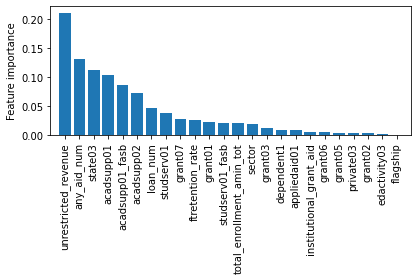

In [31]:
importances = rf_final.feature_importances_

indices = np.argsort(importances)[::-1]

plt.ylabel('Feature importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

feat_labels = df_mice.columns[1:]
plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)

plt.xlim([-1, X_train.shape[1]])

plt.tight_layout()
plt.show()